In [ ]:
# script to replace the base mechanism with new reactions (every reaction calculated) and species (all species calculated for now)

In [1]:
import os
import pickle
import datetime
import subprocess
import numpy as np

import rmgpy.chemkin
import rmgpy.data.kinetics
# import cantera as ct


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the base model
basedir = '/home/moon/autoscience/autoscience/paper/models/pentane'
new_model_dir = basedir
base_chemkin = os.path.join(basedir, 'chem_annotated_fixed.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)
print(f'{len(species_list)} species, {len(reaction_list)} reactions')


189 species, 3837 reactions


In [3]:
# Load the new kinetics library
DFT_DIR = "/home/moon/autoscience/autoscience/butane/dft/"
kinetics_lib = os.path.join(DFT_DIR, 'kinetics', 'kinetics')
ark_kinetics_database = rmgpy.data.kinetics.KineticsDatabase()
ark_kinetics_database.load_libraries(kinetics_lib)
print(f'{len(ark_kinetics_database.libraries[""].entries)} entries loaded')

105 entries loaded


In [10]:
# load the uncertainty matrix
thermo_uncertainty_file = '/home/moon/autoscience/autoscience/paper/models/pentane/species_uncertainty.npy'
kinetic_uncertainty_file = '/home/moon/autoscience/autoscience/paper/models/pentane/reaction_uncertainty.npy'

thermo_uncertainty = np.load(thermo_uncertainty_file)
kinetic_uncertainty = np.load(kinetic_uncertainty_file)

assert len(kinetic_uncertainty) == len(reaction_list)
assert len(thermo_uncertainty) == len(species_list)

uncertainty_cutoff = 2.5

reaction_change_list = []
for i in range(0, len(reaction_list)):
    if kinetic_uncertainty[i] > uncertainty_cutoff:
        reaction_change_list.append(i)

thermo_change_list = []
for i in range(0, len(species_list)):
    if thermo_uncertainty[i] > uncertainty_cutoff:
        thermo_change_list.append(i)



In [11]:
len(reaction_change_list)

945

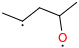

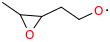

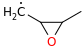

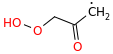

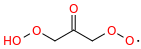

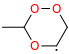

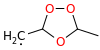

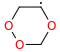

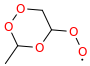

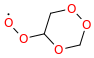

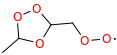

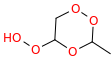

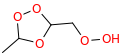

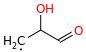

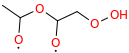

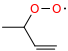

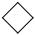

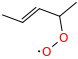

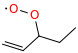

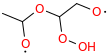

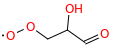

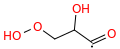

In [12]:
for i in thermo_change_list:
    display(species_list[i])

In [13]:
# change the kinetics

total_changed = 0
for key in ark_kinetics_database.libraries[''].entries.keys():
    entry = ark_kinetics_database.libraries[''].entries[key]
    index = entry.index
#     print(index, '\t', entry.label, '\t', reaction_list[index])
    for i in range(0, len(reaction_list)):
        if entry.item.is_isomorphic(reaction_list[i]):
            rmg_rxn_index = i
            break
    else:
        # search through all for isomorphism
        for j, rxn in enumerate(reaction_list):
            if entry.item.is_isomorphic(rxn):
                rmg_rxn_index = j
                break
        else:
            print(f'could not match reaction index {index}')
        continue
    
    if rmg_rxn_index in reaction_change_list:
        print(f'changing reaction {rmg_rxn_index} {reaction_list[rmg_rxn_index]}')
        reaction_list[rmg_rxn_index].kinetics = entry.data
        total_changed += 1

print(total_changed, 'changed')

changing reaction 260 HO2(16) + C2H5(33) <=> H2O2(17) + C2H4(11)
could not match reaction index 247
could not match reaction index 278
could not match reaction index 288
could not match reaction index 290
could not match reaction index 294
could not match reaction index 313
could not match reaction index 324
could not match reaction index 325
could not match reaction index 326
could not match reaction index 370
could not match reaction index 371
could not match reaction index 402
could not match reaction index 411
changing reaction 422 HO2(16) + CH3CO(20) <=> H2O2(17) + CH2CO(24)
changing reaction 423 HO2(16) + CH2CHO(21) <=> H2O2(17) + CH2CO(24)
could not match reaction index 420
could not match reaction index 422
changing reaction 454 CH2CHO(21) + CH2CHO(21) <=> CH2CO(24) + CH3CHO(35)
could not match reaction index 433
could not match reaction index 445
changing reaction 646 CH3O(31) + C3H5-A(94) <=> CH2O(9) + C3H6(12)
could not match reaction index 579
changing reaction 644 CH2CHO(2

In [ ]:
ark_kinetics_database.libraries[''].entries[247].item

In [ ]:
ref_rxn.reactants[0]

In [ ]:
ref_rxn = ark_kinetics_database.libraries[''].entries[247].item

for i, rxn in enumerate(reaction_list):
    if len(rxn.reactants) != 2:
        continue
        
    if ref_rxn.reactants[0].is_isomorphic(rxn.reactants[0]) or ref_rxn.reactants[0].is_isomorphic(rxn.reactants[1]):
        print(i, rxn)
#                                           if rxn.products[0].is_isomorphic(ref_rxn.products[0]) or rxn.products[1].is_isomorphic(ref_rxn.products[1]):
#         print(i, rxn)
#     elif rxn.products[0].is_isomorphic(ref_rxn.products[1]) or rxn.products[1].is_isomorphic(ref_rxn.products[0]):
#         print(i, rxn)
# #     for p in rxn.products

# 

In [7]:
# Load the new thermo library
thermo_lib = os.path.join(DFT_DIR, 'thermo', 'thermo')
ark_thermo_database = rmgpy.data.thermo.ThermoDatabase()
ark_thermo_database.load_libraries(thermo_lib)
print(f'{len(ark_thermo_database.libraries["harris_butane"].entries)} entries')

110 entries


In [8]:
# stitch each of the library thermos into the mechanism

sp_changed = 0
for key in ark_thermo_database.libraries['harris_butane'].entries.keys():
    entry = ark_thermo_database.libraries['harris_butane'].entries[key]
#     print(entry)

    for i, species in enumerate(species_list):
#         if entry.item.is_isomorphic(species.molecule[0]):
        if entry.item.smiles == species.smiles:
            rmg_species_index = i
            break
    else:
        entry_sp = rmgpy.species.Species(smiles=entry.item.smiles)
        for j, species in enumerate(species_list):
            if entry_sp.is_isomorphic(species.molecule[0]):
                rmg_species_index = i
                'matched'
                break
        else:
#             print(f'could not match species index {entry}')
            continue
            raise ValueError (f'could not match species index {entry}')

    if rmg_species_index in thermo_change_list:
        print(f'Changing estimated thermo {rmg_species_index}: {species_list[rmg_species_index]}')
        species_list[rmg_species_index].thermo = entry.data
        
        sp_changed += 1
    
print(sp_changed, 'changed')   

Changing estimated thermo 118: [CH2]C[O](761)
Changing estimated thermo 114: [CH2]C[CH]C(685)
Changing estimated thermo 126: [CH2]C(=O)COO(986)
Changing estimated thermo 129: [O]OCC(=O)COO(1064)
Changing estimated thermo 135: [O]C[O](3198)
Changing estimated thermo 137: [CH2]C=C[CH2](3731)
Changing estimated thermo 164: C=CC(C)O[O](13318)
Changing estimated thermo 165: CC=CCO[O](13319)
Changing estimated thermo 166: [CH2]C1CC1(13509)
9 changed


In [9]:
# custom save
chemkin_file = os.path.join(new_model_dir, f'pentane_cutoff3_20230104.inp')
rmgpy.chemkin.save_chemkin_file(chemkin_file, species_list, reaction_list, verbose=True, check_for_duplicates=True)
subprocess.run(['ck2cti', f'--input={chemkin_file}', f'--transport={transport}', f'--output={chemkin_file[:-4]}.cti'])


Wrote CTI mechanism file to '/home/moon/autoscience/autoscience/paper/models/pentane/pentane_cutoff3_20230104.cti'.
Mechanism contains 189 species and 3874 reactions.
Validating mechanism...FAILED.

***********************************************************************
InputFileError thrown by Kinetics::checkDuplicates:
Undeclared duplicate reactions detected:
Reaction 2442: 2 CH3CHO(35) <=> 2 C2H4O(947)
Reaction 2409: C2H4O(947) <=> CH3CHO(35)
***********************************************************************



CompletedProcess(args=['ck2cti', '--input=/home/moon/autoscience/autoscience/paper/models/pentane/pentane_cutoff3_20230104.inp', '--transport=/home/moon/autoscience/autoscience/paper/models/pentane/tran.dat', '--output=/home/moon/autoscience/autoscience/paper/models/pentane/pentane_cutoff3_20230104.cti'], returncode=1)